In [1]:
from IPython import get_ipython

  ---

  # Assignment 2.
  ** *02806 Social data analysis and visualization* **

  ** *Mar. 2021* **

  ---

  ---

  # Part 2A: Random forest binary classification.

  ---

  ---

  ## Importing needed libraries:

  ---

In [2]:
""" for Data Handeling """
import numpy as np 
import pandas as pd 
import calendar
import os 

""" for Display """
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

""" for Statistic """
from scipy.stats import ks_2samp

""" for Cross Validation """
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

""" for Evaluation Metrics """ 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

""" for Data Preprocessing  """
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

""" for Models """
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

  ---

  ## Loading Crime Data

  ---

In [3]:
""" Importing dataset """ 
data_dir = r"C:\Users\boody\OneDrive - Danmarks Tekniske Universitet\01 MSc\2st Semester\01_SD\GitHub_Group\social-data-analysis\Datasets\Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv"
Data = pd.read_csv(data_dir, usecols=['Category', 'Date', 'Time','DayOfWeek', 'PdDistrict', 'Y']) 

""" slice the two selected crimes Categories """
Selected_Crimes = ['BURGLARY','FRAUD']
Data = Data[Data['Category'].isin(Selected_Crimes)]

""" add 'Hour' feature by transfering 'Date' to numeric 'Hour' """
Data['Hour'] = pd.to_datetime(Data['Time']).dt.hour

""" add 'Month' feature by transfering 'Date' """
Data['Month'] = pd.to_datetime(Data['Date']).dt.month

""" overview """
Data.head(n=5)

,Category,DayOfWeek,Date,Time,PdDistrict,Y,Hour,Month
33,BURGLARY,Sunday,03/25/2018,03:00,MISSION,37.766246,3,3
40,BURGLARY,Monday,11/27/2017,03:14,SOUTHERN,37.775421,3,11
46,FRAUD,Sunday,03/25/2018,01:00,SOUTHERN,37.790965,1,3
70,BURGLARY,Tuesday,02/28/2017,02:37,TENDERLOIN,37.782495,2,2
79,BURGLARY,Sunday,04/08/2018,12:30,TENDERLOIN,37.784912,12,4



 ---
 ## Test for different spatio-temporal distribution
 ---

 **Kolmogorov-Smirnov statistic** of the two selected crime categories BURGLARY and FRAUD:

In [4]:
""" Kolmogorov-Smirnov on Y """
d1 = Data[Data['Category'] == Selected_Crimes[0]]['Y']
d2 = Data[Data['Category'] == Selected_Crimes[1]]['Y']
print("Test for Different distribution under \u03B1 = 0.5 is: ", ks_2samp(d1, d2)[1]<0.5)

Test for Different distribution under α = 0.5 is:  True


In [5]:
""" Kolmogorov-Smirnov on Hour """
d1 = Data[Data['Category'] == Selected_Crimes[0]]['Hour']
d2 = Data[Data['Category'] == Selected_Crimes[1]]['Hour']
print("Test for Different distribution under \u03B1 = 0.5 is: ", ks_2samp(d1, d2)[1]<0.5)

Test for Different distribution under α = 0.5 is:  True


In [6]:
""" Kolmogorov-Smirnov on Month  """
d1 = Data[Data['Category'] == Selected_Crimes[0]]['Month']
d2 = Data[Data['Category'] == Selected_Crimes[1]]['Month']
print("Test for Different distribution under \u03B1 = 0.5 is: ", ks_2samp(d1, d2)[1]<0.5)

Test for Different distribution under α = 0.5 is:  True


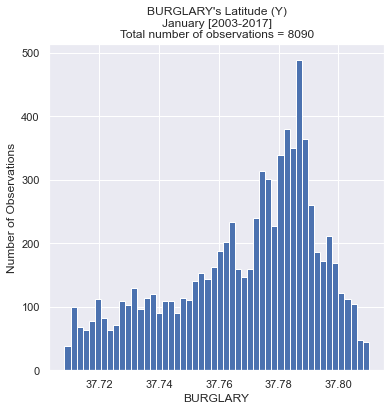

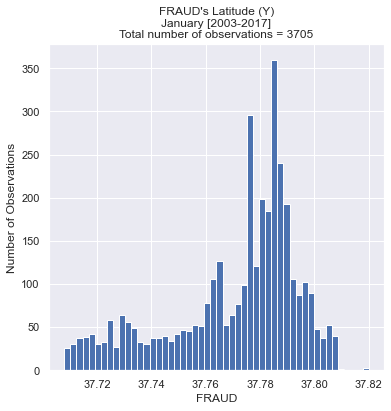

In [29]:
""" Plot the Selected two crime categories for jan [2003-2017] """
for crime in Selected_Crimes:
    d = Data[Data['Category'] == crime]
    d = d[d['Month']==1]
    plt.figure(figsize=(6, 6))
    plt.hist(d['Y'], bins=50) 
    plt.title( crime + "'s Latitude (Y)" + '\nJanuary [2003-2017]''\nTotal number of observations = '+ str(len(d)))
    plt.xlabel(crime)
    plt.ylabel('Number of Observations')
    plt.show()

""" free memory """
del (d,d1,d2)

Above is a visualization of how the two crimes Fraud and Burglary are distributed on January from 2013 until 2018 using 50 bins  

 ---

 ## Slice needed features for learning

 ---

In [30]:
""" slice features: Category and the four selected features Month, DayOfWeek, Hour and PdDistrict """
data = Data[['Category','Month','DayOfWeek','Hour','PdDistrict']].copy()

""" overview """
data.head(n=5)

,Category,Month,DayOfWeek,Hour,PdDistrict
33,BURGLARY,3,Sunday,3,MISSION
40,BURGLARY,11,Monday,3,SOUTHERN
46,FRAUD,3,Sunday,1,SOUTHERN
70,BURGLARY,2,Tuesday,2,TENDERLOIN
79,BURGLARY,4,Sunday,12,TENDERLOIN


 ---

 ## Define Data Preprocessor:

 ---

 will be used as a first step in the pipeline models
 for **data proccessing**

In [31]:
numeric_transformer = StandardScaler()
categorical_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('lenc', OrdinalEncoder()),
        ('stand', StandardScaler())
        ])

preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, selector(dtype_include="int64")),
        ('cat', categorical_transformer, selector(dtype_include="object"))
        ])

 ---

 ## Class Balance:

 ---

 Here we will use the **Down-sample Majority Class** method
 see [link](https://elitedatascience.com/imbalanced-classes)

In [43]:
""" count data """
print('Count categories before Class Balance:')
print(data['Category'].value_counts())

""" Separate majority and minority classes """
data_majority   = data[data['Category']==Selected_Crimes[0]]
data_minority   = data[data['Category']==Selected_Crimes[1]]
 
""" Downsample class """
seed = 123
data_majority = resample(data_majority, 
                    replace=False,                  # sample without replacement
                    n_samples=len(data_minority),   # to match minority class
                    random_state=seed)              # reproducible results

data_minority = resample(data_minority, 
                    replace=False,                  # sample without replacement
                    n_samples=len(data_minority),   # to match minority class
                    random_state=seed)              # reproducible results


""" Combine minority class with downsampled majority class """
data_downsampled = pd.concat([data_majority, data_minority])

""" Shuffle DataFrame rows and reset index """
data_downsampled = data_downsampled.sample(frac=1, random_state=seed).reset_index(drop=True)

""" Check and Display new class counts """
print('\nCount categories after Class Balance:')
print(data_downsampled['Category'].value_counts())

""" free memory """
del(data_majority,data_minority,data)

Count categories before Class Balance:
BURGLARY    91067
FRAUD       41348
Name: Category, dtype: int64

Count categories after Class Balance:
BURGLARY    41348
FRAUD       41348
Name: Category, dtype: int64


 ---

 ## Split data for Learning

 ---

In [48]:
""" Split-out X,Y dataset """
X = data_downsampled.iloc[:,1:]
Y = data_downsampled.iloc[:,0]

""" Split-out validation dataset """
validation_size = 0.8  
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,test_size=validation_size, random_state=seed, stratify=Y)
print (f'{len(Y_train)} samples to train on and {len(Y_validation)} to validate the final model on (unseen data)')

16539 samples to train on and 66157 to validate the final model on (unseen data)


 ---

 ## Compare Algorithms

 ---

 **RandomForest vs DecisionTree** (Both with sklearn Default settings):

 10 fold CV

RF: Accuracy = 0.581 +/- (0.017)
DT: Accuracy = 0.564 +/- (0.015)


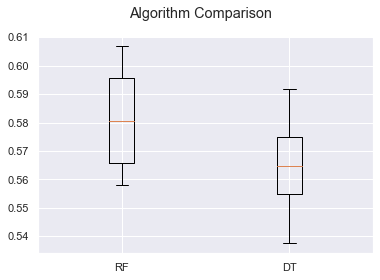

In [53]:
pipelines = []
pipelines.append(('RF', Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier())])))
pipelines.append(('DT', Pipeline([('preprocessor', preprocessor),('dt',DecisionTreeClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10,shuffle= True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy = %.3f +/- (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Above is the Box and Whisker Plots Comparing Algorithm Performance. It's seen that RandomForestClassifier is doing much better.  

 ---

 ## RandomForestClassifier tuning:

 ---

 - Explore Number of Trees    (n_estimators)      = to be investegated with CV.
 - Explore Minimum Node Size  (min_samples_leaf)  = to be investegated with CV.


 - Explore Number of Features (max_features)      = 'sqrt' (Heuristic: the square root of the number of input features).
 - Explore the quality of a split (criterion)     = entropy(Heuristic: a measure of information that indicates the disorder of the features with the target).

 ### Random Grid Search
 with **3X3 Repeated Stratified KFold** to find hyperparameters focus area:

In [55]:
model = Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier(max_features = 'sqrt', criterion = 'entropy'))])
n_estimators = [100,500,1000,2000]
min_samples_leaf = [1, 50, 100, 200]
random_grid = {'rf__n_estimators': n_estimators,
               'rf__min_samples_leaf':min_samples_leaf }

s_kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=seed)
grid  = RandomizedSearchCV(estimator = model, param_distributions = random_grid, scoring='accuracy', n_iter = 10, cv = s_kfold, verbose=2, n_jobs = -1)
grid_result = grid.fit(X_train, Y_train)

print('Accuracy:     %.3f' % grid_result.best_score_)
print('random_best_params_:   %s' % grid_result.best_params_)

Fitting 9 folds for each of 10 candidates, totalling 90 fits
Accuracy:     0.627
random_best_params_:   {'rf__n_estimators': 1000, 'rf__min_samples_leaf': 50}


 ### Grid Search
 with **3X3 Repeated Stratified KFold** to find the best hyperparameters within the Random Grid Search focus area.

In [56]:
model = Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier(max_features = 'sqrt', criterion = 'entropy'))])

n_estimators = [750, 1000, 1250]
min_samples_leaf = [25, 50, 75]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__min_samples_leaf':min_samples_leaf }

s_kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='accuracy', cv = s_kfold, n_jobs = -1, verbose = 2)
grid_result = grid.fit(X_train, Y_train)

print('Accuracy:     %.3f' % grid_result.best_score_)
print('best_params_:   %s' % grid_result.best_params_)

Fitting 9 folds for each of 9 candidates, totalling 81 fits
Accuracy:     0.628
best_params_:   {'rf__min_samples_leaf': 50, 'rf__n_estimators': 1250}


 ---

 ## Prepare Final Model

 ---

 with Grid Search **best founded hyperparameters**

In [57]:
model = Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier(n_estimators= 1250, min_samples_leaf = 50, max_features = 'sqrt', criterion = 'entropy'))])
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC83E65948>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('lenc',
                                                                   OrdinalEncoder()),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC83E65408>)])),
                ('rf',
                 

 ---

 ## Report:

 ---

In [60]:
predictions = model.predict(X_validation)
print('Accuracy= %.3f' % accuracy_score(Y_validation, predictions))
print('\nConfusion Matrix:\n', confusion_matrix(Y_validation, predictions))
print('\nClassification Report:\n',classification_report(Y_validation, predictions))

Accuracy= 0.632

Confusion Matrix:
 [[22101 10978]
 [13335 19743]]

Classification Report:
               precision    recall  f1-score   support

    BURGLARY       0.62      0.67      0.65     33079
       FRAUD       0.64      0.60      0.62     33078

    accuracy                           0.63     66157
   macro avg       0.63      0.63      0.63     66157
weighted avg       0.63      0.63      0.63     66157



 ---

 ## (Optional) Feature selection with Permutation feature importance:

 ---
 10 fold CV

In [61]:
result = permutation_importance(model, X_train, Y_train, n_repeats=10,random_state=seed, scoring='accuracy')
col_names = list(X_train.columns)

for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
         print(f"{col_names[i]:<20}"
               f"{result.importances_mean[i]:.3f}"
               f" +/- {result.importances_std[i]:.3f}")

Hour                0.117 +/- 0.002
PdDistrict          0.048 +/- 0.002
DayOfWeek           0.011 +/- 0.001
Month               0.011 +/- 0.001


---
# Discussion: 
---

**Explain about your choices for training/test data, features, and encoding. (You decide how to present your results, but here are some example topics to consider: Did you balance the training data? What are the pros/cons of balancing? Do you think your model is overfitting? Did you choose to do cross-validation? Which specific features did you end up using? Why? Which features (if any) did you one-hot encode? Why ... or why not?))**

> Below is a summary of the algorithm we used to approach solving the classification problem at hand:
- Load Crime Dataset. 
- Check that the selected two crimes have indeed different Spatio-temporal distribution (Kolmogorov-Smirnov statistic).
- Balance Dataset.
- Defined a Data Preprocessor (To be used in each cross-validate fold to prevent leaking information from training to test data).  
- Split Data in stratified way randomly, 20% training 80% validation. (20% to train on is still a lot of data).
- Compare both models with naive (SKlearn deafult) parameters (10 fold CV: Random-forest vs decision tree).
- Start tuning the best performing algorithm: 
    - Random Grid Search (2-level CV: 3 X 3) to find hyperparameters focus area.
    - Grid Search (2-level CV: 3 X 3) to find the best combination of hyperparameters within the Random grid search focus area.
- Define the final model according to the best combination of hyperparameters founded using the Grid search. 
- Validate the final model on the validation (unseen) data set and report. 
- Optional: Investigate which features are the most important (for later improvement).

> Below is a clarification of the choices we made: 
- Choices of features: 
  - We choose the following features: 'Category', 'Month' ,'DayOfWeek', 'Hour' and 'PdDistrict' to include in our model 
  as they best describe the Spatio-temporal patterns of a Crime.
- Chosen of label encoding: 
  - The number of categories is a bit large within the categorical variables and one-hot encoding can lead to high memory consumption.
  - label encoding can lead to an ordinality problem which means that not-ordinal variables will have an order. Howeever,
  decisions trees work based on increasing the homogeneity of the next level. Thus, it might not be a big problem to label encode the categorical variable here.   
- Choice for class balance: 
  - Since we don't want to increase the probability of classifying any new random point as the class with more examples.
  - The coins is that our model will be trained in a way that emphasizes the minority classes more in favour of the majority class which might not represent the real population.  
- Choices for training/test data:  
  - Split Data 20% by for training and 80% validation since:  
    - We indeed have a lot of data! 20% correspond to 16539 samples to train and 80% correspond to 66157 samples (unseen data) to validate the final model. 
    - Having relatively more data to validate the final can give a more generalized sense of how the model would act on future data. 
    - Having a relatively less but reasonable amount of data(> 10,000) to train on would reduce the computational power needed to tune the model. 
  - Tuning the model with 2 level CV: 3 X 3 since: 
    - We want to calculate the expected performance of the CV-optimized hyper-parameters. Thus, we choose 2 level CV.   
    - We want to Minimize the testing bias by having a sufficiently large portion of the dataset for training. Thus, we choose 2/3 of the training data to train on.
    - we want to Minimize the testing variance by having a sufficiently large portion of the dataset for testing. Thus, we choose 1/3 of the training data to test on.
    - only 3 and not 5 fold in the inner and outer folds of the CV since we want to improve the computational power needed.
- Overfitting
  - Our model generalizes very well to the validation data (new unseen data) which means that our model is not overfitting.


**Report accuracy. Discuss the model performance.**
>*Accuracy* = 0.632

>*Confusion Matrix:*
>
|       |       |     
| ----- | ----- | 
| 22101 | 10978 | 
| 13335 | 19743 |  


>*Classification Report:*
>
|| precision | recall |
|  ------  | --------- | ------ | 
| BURGLARY | 0.62      | 0.67   | 
| FRAUD    | 0.64      | 0.60   |

>Above are the reported measures of the final model on the validation (unseen) data set.
as can be seen, the final model has somewhat a good accuracy and it's not misleading since we also have good precision and recall (see Classification Report & Confusion Matrix). Thus, Our model can be generalised to future data and does not overfit the training data. 

  ---

  # Part 2B: Info from weather features.

  ---

 ---

 Load Weather Data

 ---

In [73]:
""" Importing weather dataset """
weather_url = 'https://raw.githubusercontent.com/suneman/socialdata2021/master/files/weather_data.csv'
weather_data = pd.read_csv(weather_url) 

 ---

 ## Merge: Data = weatherdata + crimedata

 ---

In [74]:
""" Shift Weather time-zone """
weather_data['date'] = weather_data['date'].apply(lambda x: pd.to_datetime(x).tz_convert(None).tz_localize("Etc/GMT+3").tz_convert("Etc/GMT-7")) 

""" Shift Crime time-zone """
Data['datetime'] = Data.apply(lambda x: pd.to_datetime(x.Date + " " + x.Time).round("H").tz_localize("ETC/GMT-7"), axis = 1)

""" Merge weather and crime Data """
weather_data = weather_data.rename(columns={'date':'datetime'})
Data = Data.merge(weather_data, on='datetime', how= 'inner')

""" Free memory """
del (weather_data)

 ## Check if all entries has weather info:

In [75]:
temperature_check      = sum(pd.isnull(Data['temperature']))
humidity_check         = sum(pd.isnull(Data['humidity']))
weather_check          = sum(pd.isnull(Data['weather']))
wind_speed_check       = sum(pd.isnull(Data['wind_speed']))
wind_direction_check   = sum(pd.isnull(Data['wind_direction']))
pressure_check         = sum(pd.isnull(Data['pressure']))
sum_checks = temperature_check + humidity_check + weather_check + wind_speed_check  + wind_direction_check + pressure_check
print (f'number of temperature missing values = {sum_checks}')

number of temperature missing values = 2


 ## Delete messing values and Rearrange Merged Data:

In [83]:
""" Delete messing values: """  
Data = Data.dropna()

""" Delete unneeded columns """
Data = Data.drop(columns=['Date','Time'])

""" Rename datetime column """
Data = Data.rename(columns={'datetime':'Date'})

 ## Overview of Merged Data:

In [86]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44537 entries, 0 to 44538
Data columns (total 13 columns):
Category          44537 non-null object
DayOfWeek         44537 non-null object
PdDistrict        44537 non-null object
Y                 44537 non-null float64
Hour              44537 non-null int64
Month             44537 non-null int64
Date              44537 non-null datetime64[ns, Etc/GMT-7]
temperature       44537 non-null float64
humidity          44537 non-null float64
weather           44537 non-null object
wind_speed        44537 non-null float64
wind_direction    44537 non-null float64
pressure          44537 non-null float64
dtypes: datetime64[ns, Etc/GMT-7](1), float64(6), int64(2), object(4)
memory usage: 4.8+ MB


In [87]:
Data.head()

,Category,DayOfWeek,PdDistrict,Y,Hour,Month,Date,temperature,humidity,weather,wind_speed,wind_direction,pressure
0,BURGLARY,Tuesday,TENDERLOIN,37.782495,2,2,2017-02-28 03:00:00+07:00,8.07,61.0,few clouds,1.0,360.0,1015.0
1,BURGLARY,Wednesday,MISSION,37.753019,2,6,2016-06-22 02:00:00+07:00,23.19,72.0,sky is clear,0.0,180.0,1015.0
2,BURGLARY,Wednesday,RICHMOND,37.783008,2,6,2016-06-22 02:00:00+07:00,23.19,72.0,sky is clear,0.0,180.0,1015.0
3,BURGLARY,Tuesday,TARAVAL,37.737477,14,10,2017-10-10 14:00:00+07:00,18.14,67.0,smoke,1.0,40.0,1013.0
4,BURGLARY,Tuesday,INGLESIDE,37.741506,11,5,2017-05-16 12:00:00+07:00,17.71,60.0,haze,5.0,288.0,1016.0


 ---
 ## Test for different spatio-temporal distribution
 ---
 **Kolmogorov-Smirnov statistic** of the two selected crime categories BURGLARY and FRAUD:

In [89]:
""" Kolmogorov-Smirnov on Y """
d1 = Data[Data['Category'] == Selected_Crimes[0]]['Y']
d2 = Data[Data['Category'] == Selected_Crimes[1]]['Y']
print("Test for different distribution under \u03B1 = 0.5 is: ", ks_2samp(d1, d2)[1]<0.5)

Test for different distribution under α = 0.5 is:  True


In [90]:
""" Kolmogorov-Smirnov on Hour """
d1 = Data[Data['Category'] == Selected_Crimes[0]]['Hour']
d2 = Data[Data['Category'] == Selected_Crimes[1]]['Hour']
print("Test for different distribution under \u03B1 = 0.5 is: ", ks_2samp(d1, d2)[1]<0.5)

Test for different distribution under α = 0.5 is:  True


In [91]:
""" Kolmogorov-Smirnov on Month  """
d1 = Data[Data['Category'] == Selected_Crimes[0]]['Month']
d2 = Data[Data['Category'] == Selected_Crimes[1]]['Month']
print("Test for different distribution under \u03B1 = 0.5 is: ", ks_2samp(d1, d2)[1]<0.5)

Test for different distribution under α = 0.5 is:  False


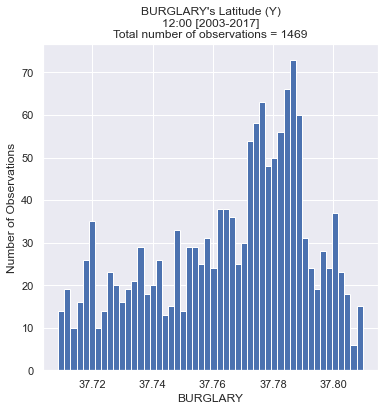

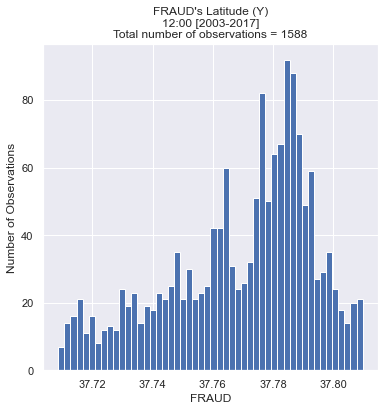

In [92]:
""" Plot the Selected two crime categories at 12:00 [2003-2017] """
for crime in Selected_Crimes:
    d = Data[Data['Category'] == crime]
    d = d[d['Hour']==12]
    plt.figure(figsize=(6, 6))
    plt.hist(d['Y'], bins=50) 
    plt.title( crime + "'s Latitude (Y)" + '\n12:00 [2003-2017]''\nTotal number of observations = '+ str(len(d)))
    plt.xlabel(crime)
    plt.ylabel('Number of Observations')
    plt.show()

""" free memory """
del (d,d1,d2)

Above is a visualization of how the two crimes Fraud and Burglary are distributed at 12:00-13:00 from 2013 until 2018 using 50 bins  

 ---
 ## Slice needed data
 ---

In [94]:
""" drop Date and Y """
data = Data.drop(columns=['Date', 'Y']).copy()

""" free memory """
del(Data)

 ---

 ## Define Data Preprocessor:

 ---

 will be used as a first step in the pipelines models
 for **data proccessing**

In [95]:
numeric_transformer = StandardScaler()


categorical_transformer = Pipeline(
        steps = [
        ('enc', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)),
        ('stand', StandardScaler())
        ])

preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="object")),
        ('cat', categorical_transformer, selector(dtype_include="object"))
        ])

 ---

 ## Class Balance:

 ---

 Here we will use the **Down-sample Majority Class** method
 see [link](https://elitedatascience.com/imbalanced-classes)

In [96]:
""" count data """
print('Count categories before Class Balance:')
print(data['Category'].value_counts())

""" Separate majority and minority classes """
data_majority   = data[data['Category']==Selected_Crimes[0]]
data_minority   = data[data['Category']==Selected_Crimes[1]]
 
""" Downsample class """
seed = 123
data_majority = resample(data_majority, 
                    replace=False,                  # sample without replacement
                    n_samples=len(data_minority),   # to match minority class
                    random_state=seed)              # reproducible results

data_minority = resample(data_minority, 
                    replace=False,                  # sample without replacement
                    n_samples=len(data_minority),   # to match minority class
                    random_state=seed)              # reproducible results


""" Combine minority class with downsampled majority class """
data_downsampled = pd.concat([data_majority, data_minority])

""" Shuffle DataFrame rows and reset index """
data_downsampled = data_downsampled.sample(frac=1, random_state=seed).reset_index(drop=True)

""" Check and Display new class counts """
print('\nCount categories after Class Balance:')
print(data_downsampled['Category'].value_counts())

""" free memory """
del(data_majority,data_minority,data)

Count categories before Class Balance:
BURGLARY    30236
FRAUD       14301
Name: Category, dtype: int64

Count categories after Class Balance:
FRAUD       14301
BURGLARY    14301
Name: Category, dtype: int64


 ---

 ## Split data for Learning

 ---

In [97]:
""" Split-out X,Y dataset """
X = data_downsampled.iloc[:,1:]
Y = data_downsampled.iloc[:,0]

""" Split-out validation dataset """
validation_size = 0.6  
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,test_size=validation_size, random_state=seed, stratify=Y)
print (f'{len(Y_train)} samples to train on and {len(Y_validation)} to validate the final model on (unseen data)')

11440 samples to train on and 17162 to validate the final model on (unseen data)


 ---

 ## Compare Algorithms

 ---

 **RandomForest vs DecisionTree** (Both with sklearn Default settings):

 10 fold CV

RF: Accuracy = 0.599 +/- (0.015)
DT: Accuracy = 0.553 +/- (0.012)


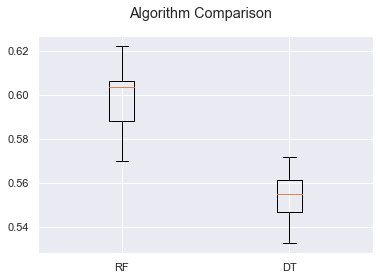

In [98]:
pipelines = []
pipelines.append(('RF', Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier())])))
pipelines.append(('DT', Pipeline([('preprocessor', preprocessor),('dt',DecisionTreeClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10,shuffle= True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy = %.3f +/- (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Above is the Box and Whisker Plots Comparing Algorithm Performance. It's seen that RandomForestClassifier is doing much better.  

 ---

 ## RandomForestClassifier tuning:

 ---

 - Explore Number of Trees    (n_estimators)      = to be investegated with CV.
 - Explore Minimum Node Size  (min_samples_leaf)  = to be investegated with CV.



 - Explore Number of Features (max_features)      = 'sqrt' (Heuristic: the square root of the number of input features).
 - Explore the quality of a split (criterion)     = entropy(Heuristic: a measure of information that indicates the disorder of the features with the target).

 ### Random Grid Search
 with **3X3 Repeated Stratified KFold** for hyperparameters focus area:

In [99]:
model = Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier(max_features = 'sqrt', criterion = 'entropy'))])

n_estimators = [100,500,1000,2000]
min_samples_leaf = [1, 50, 100, 200]
random_grid = {'rf__n_estimators': n_estimators,
               'rf__min_samples_leaf':min_samples_leaf }

s_kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=seed)
grid  = RandomizedSearchCV(estimator = model, param_distributions = random_grid, scoring='accuracy', n_iter = 10, cv = s_kfold, verbose=2, n_jobs = -1)
grid_result = grid.fit(X_train, Y_train)

print('Accuracy:     %.3f' % grid_result.best_score_)
print('random_best_params_:   %s' % grid_result.best_params_)

Fitting 9 folds for each of 10 candidates, totalling 90 fits
Accuracy:     0.623
random_best_params_:   {'rf__n_estimators': 500, 'rf__min_samples_leaf': 50}


 ### Grid Search
 with **3X3 Repeated Stratified KFold** to find the best hyperparameters within the Random Grid Search focus area.

In [100]:
model = Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier(max_features = 'sqrt', criterion = 'entropy'))])

n_estimators = [250, 500, 750]
min_samples_leaf = [25, 50, 75]
param_grid = {'rf__n_estimators': n_estimators,
              'rf__min_samples_leaf':min_samples_leaf }

s_kfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='accuracy', cv = s_kfold, n_jobs = -1, verbose = 2)
grid_result = grid.fit(X_train, Y_train)

print('Accuracy:     %.3f' % grid_result.best_score_)
print('best_params_:   %s' % grid_result.best_params_)

Fitting 9 folds for each of 9 candidates, totalling 81 fits
Accuracy:     0.624
best_params_:   {'rf__min_samples_leaf': 25, 'rf__n_estimators': 750}


 ---

 ## Prepare Final Model

 ---

 with Grid Search **best founded hyperparameters**

In [101]:
model = Pipeline([('preprocessor', preprocessor),('rf',RandomForestClassifier(n_estimators= 750, min_samples_leaf = 25, max_features = 'sqrt', criterion = 'entropy'))])
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC865EC9C8>),
                                                 ('cat',
                                                  Pipeline(steps=[('enc',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC865ECD08>)])),
                ('rf',
                 RandomForestClassifier(criterion='entropy',
          

 ---

 ## Report:

 ---

In [102]:
predictions = model.predict(X_validation)
print('Accuracy= %.3f' % accuracy_score(Y_validation, predictions))
print('\nConfusion Matrix:\n', confusion_matrix(Y_validation, predictions))
print('\nClassification Report:\n',classification_report(Y_validation, predictions))

Accuracy= 0.625

Confusion Matrix:
 [[5387 3194]
 [3237 5344]]

Classification Report:
               precision    recall  f1-score   support

    BURGLARY       0.62      0.63      0.63      8581
       FRAUD       0.63      0.62      0.62      8581

    accuracy                           0.63     17162
   macro avg       0.63      0.63      0.63     17162
weighted avg       0.63      0.63      0.63     17162



 ---

 ## (Optional) Feature selection with Permutation feature importance:

 ---
 10 fold CV

In [104]:
result = permutation_importance(model, X_train, Y_train, n_repeats=10,random_state=seed, scoring='accuracy')
col_names = list(X_train.columns)

for i in result.importances_mean.argsort()[::-1]:
     if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
         print(f"{col_names[i]:<20}"
               f"{result.importances_mean[i]:.3f}"
               f" +/- {result.importances_std[i]:.3f}")

Hour                0.144 +/- 0.005
PdDistrict          0.052 +/- 0.002
wind_direction      0.041 +/- 0.001
temperature         0.039 +/- 0.002
humidity            0.031 +/- 0.002
pressure            0.019 +/- 0.001
Month               0.016 +/- 0.001
weather             0.015 +/- 0.001
wind_speed          0.014 +/- 0.001
DayOfWeek           0.013 +/- 0.001


---
# Discussion: 
---

**Report accuracy.**

>*Accuracy* = 0.625

>*Confusion Matrix:*
>
|       |       |     
| ----- | ----- | 
| 5387 | 3194 | 
| 3237 | 5344 |  

>*Classification Report:*
>
|| precision | recall |
|  ------  | --------- | ------ | 
| BURGLARY | 0.62      | 0.63   | 
| FRAUD    | 0.63      | 0.62   |

> Above are the reported measures of the final model on the validation (unseen) data set.
as can be seen, the final model has somewhat a good accuracy and it's not misleading since we also have good precision and recall (see Classification Report & Confusion Matrix). Thus, Our model can be generalised to future data and does not overfit the training data. 

**Discuss how the model performance changes relative to the version with no weather data.**

> Actually, by adding the weather data we didn't gain any better accuracy (**decrease of 0.7 %**) or precision, recall and the memory consumption increases. However, the accuracy even though it's a little bit lower than the one we obtained by using only the crime data is still very good. This indicates that the more reliable model could be by mixing the most important features and come with a model that has some spatial-temporal and weather features. 

**Discuss what you have learned about crime from including weather data in your model.**
>What I have learned from adding the weather data, that some weather features like temperature and wind direction!
might contribute to the process of reasoning what type of crime can happen. This is cool isn't it :). I also learn that adding more info to a good performing model wouldn't necessarily increase the performance.